# Importing

## Importing modules

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, nadam, adagrad, rmsprop, adadelta

## Importing own code

In [124]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

### Analysis code

In [125]:
def plotHistory(fitDetails):
    """
    hjhgj
    """
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    maximumValue = max(max(history['loss']), max(history['val_loss']))
    minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
    numberOfEpochs = len(history['loss'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.set_xlim(1, numberOfEpochs)
    ax1.set_ylim(0, maximumValue)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss (training and validation) vs the number of epochs.')
    
    ax2.plot(history['loss'], history['val_loss'])
    ax2.set_xlim(0, maximumValue)
    ax2.set_ylim(0, maximumValue)
    ax2.set_xlabel('Training loss')
    ax2.set_ylabel('Validation loss')
    ax2.set_title('Validation loss vs training loss.')
    
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax3.legend()
    ax3.set_xlim(1, numberOfEpochs)
    ax3.set_yscale('log')
    ax3.set_ylim(minimumValue, maximumValue)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
    
    ax4.plot(history['loss'], history['val_loss'])
    ax4.set_xscale('log')
    ax4.set_xlim(minimumValue, maximumValue)
    ax4.set_yscale('log')
    ax4.set_ylim(minimumValue, maximumValue)
    ax4.set_xlabel('Training loss')
    ax4.set_ylabel('Validation loss')
    ax4.set_title('Validation loss vs training loss (logarithmic).')
    
    plt.show()
    history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [126]:
def makePredictionPlot(model, dataFrame, amountOfPoints=1000):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy')
    ax1.set_ylabel('Predicted energy')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()

In [127]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    fig, ax = plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)
    return fig, ax

### Network code

In [128]:
def makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE', optimizer=adam):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], activation=settings[0][2], kernel_initializer=kernalInitializer))
    #model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        model.add(Dense(setting[1], use_bias=setting[3], activation=setting[2], kernel_initializer=kernalInitializer))
        #model.add(Activation(setting[2]))
    
    opt = optimizer(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)
    
    return model

In [129]:
def makeLinearNet(learningRate, inputDim, loss):
    model = Sequential()
    opt = adam(lr=learningRate)
    model.add(Dense(1, activation="linear", use_bias=False, input_dim=inputDim))
    model.compile(loss=loss, optimizer=opt)
    return model

# Getting data

## Importing data and settings

In [130]:
filename = 'databaseModLen_min_cut0.90_widths86_Width1.5-10_3-1sur_epoch30_maxDelta0.1_R20_M2M3Prepared'#'OLDcombinedDataR100M2M3M4Prepared'#'combinedDataPrepared'
orderOfMatrix = [-2, -3]# Make a list if you want to do the calculations yourself and make a other type of you want to import it
inputSize=13#4 * len(orderOfMatrix)

data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
data['eigenvalues'] = data['eigenvalues'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset

Offset is 0


## Inspecting data

In [131]:
data.head()

,index,particleCoordinates,widthOfCell,numberOfSurroundingCells,potentialEnergy,eigenvalues,relativeDistances
0,55672,"[[3.186566158, 3.0836974943], [3.1829452486, 2...",4.2,3,-1.935596,"[-54686.2349094434, -120.8859876007, 463.54097...","[4.2, 0.0, 0.0, 0.0, 0.0, 0.0073141951, 2.1038..."
1,55673,"[[0.030808343300000002, 3.9898377178], [2.2342...",4.2,3,-2.614797,"[-262605.7689814073, -97.6120981259, 447.72723...","[4.2, 0.0, 0.0, 0.0, 0.0, 0.0015231843, 2.0978..."
2,55674,"[[1.9357866745, 2.8487478661], [2.5215974675, ...",4.2,3,-2.102910,"[-5151111.2188138515, -124.7984516466, 476.969...","[4.2, 0.0, 0.0, 0.0, 0.0, 7.76531e-05, 2.20213..."
3,55675,"[[0.9838372069, 4.0325820175], [0.846142479000...",4.2,3,16.754978,"[-1072.069016824, -584.5125508649, -44.2887038...","[4.2, 0.0, 0.0, 0.0, 0.0, 0.5720223109, 0.5916..."
4,55676,"[[2.7981970806, 0.0018470101], [2.992762463, 2...",4.2,3,-1.602212,"[-3368.1379365231, -113.6941026693, 295.179349...","[4.2, 0.0, 0.0, 0.0, 0.0, 0.1187724788, 1.3940..."


In [132]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,64950.000000,64950.000000,64950.0,64950.000000
mean,32474.500000,4.714582,3.0,4.847734
std,18749.594329,2.078584,0.0,66.299529
min,0.000000,1.500000,3.0,-45.142848
25%,16237.250000,3.000000,3.0,-4.341829
50%,32474.500000,4.500000,3.0,-1.726104
75%,48711.750000,6.100000,3.0,-0.651513
max,64949.000000,10.000000,3.0,2665.287506


In [133]:

"""
qLow = data['potentialEnergy'].quantile(0.01)
qHi  = data['potentialEnergy'].quantile(0.99)
dataFiltered = data.copy()
#dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()

#"""


"""
tempData = dataFiltered.copy()
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""

"""
tempData = dataFiltered.copy()
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
plt.ylim(-30, 30)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""


"\ntempData = dataFiltered.copy()\ntempOfsett = 0#1.01 * min(tempData['potentialEnergy'])\ntempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett\nmedianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])\nfig, ax = plt.subplots(figsize=(8, 8))\nax.plot(medianData.index, medianData['potentialEnergy']['min'])\nax.plot(medianData.index, medianData['potentialEnergy']['5%'])\nax.plot(medianData.index, medianData['potentialEnergy']['50%'])\nax.plot(medianData.index, medianData['potentialEnergy']['95%'])\nplt.legend(['min', '5%', '50%', '95%'])\nplt.ylim(-30, 30)\nax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')\nax.set_ylabel('Energy per particle')\nax.set_xlabel('Width of cell')\nplt.show()\n#"

## Preparing data

In [134]:
"""
trainingData={'potentialEnergy':[]}

for i in range(len(data['eigenvalues'][data.index[0]])):
    trainingData['eigenValue'+str(i)]=[]
    
for i in data.index:
    #trainingData['potentialEnergy'].append(data['potentialEnergy'][i])
    trainingData['potentialEnergy'].append(sum(data['eigenvalues'][i]))
    #print(sum(data['eigenvalues'][i]))
    for j in range(len(data['eigenvalues'][i])):
        trainingData['eigenValue'+str(j)].append(data['eigenvalues'][i][j])

trainingData = pd.DataFrame(trainingData)


#trainingData = data.copy()#data.sample(frac=0.8)
#validationData = data.copy()#data.drop(trainingData.index)

#trainingData['potentialEnergy'] = trainingData['eigenvalues'].apply(sum)

y = trainingData.iloc[:, 0:1].values
X = trainingData.iloc[:, 1:len(data['eigenvalues'][data.index[0]])+1].values

print(X)
print(y)
#print(X[0])
#print(y[0][0])

print(np.shape(X))
print(np.shape(y))
trainingData.head()"""

"\ntrainingData={'potentialEnergy':[]}\n\nfor i in range(len(data['eigenvalues'][data.index[0]])):\n    trainingData['eigenValue'+str(i)]=[]\n    \nfor i in data.index:\n    #trainingData['potentialEnergy'].append(data['potentialEnergy'][i])\n    trainingData['potentialEnergy'].append(sum(data['eigenvalues'][i]))\n    #print(sum(data['eigenvalues'][i]))\n    for j in range(len(data['eigenvalues'][i])):\n        trainingData['eigenValue'+str(j)].append(data['eigenvalues'][i][j])\n\ntrainingData = pd.DataFrame(trainingData)\n\n\n#trainingData = data.copy()#data.sample(frac=0.8)\n#validationData = data.copy()#data.drop(trainingData.index)\n\n#trainingData['potentialEnergy'] = trainingData['eigenvalues'].apply(sum)\n\ny = trainingData.iloc[:, 0:1].values\nX = trainingData.iloc[:, 1:len(data['eigenvalues'][data.index[0]])+1].values\n\nprint(X)\nprint(y)\n#print(X[0])\n#print(y[0][0])\n\nprint(np.shape(X))\nprint(np.shape(y))\ntrainingData.head()"

In [135]:

"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])#TODO remove sorted once fixed in data
    #targetData.append(trainingData['potentialEnergy'][i])
    targetData.append(sum(trainingData['eigenvalues'][i]))

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])#TODO remove sorted once fixed in data
    targetData.append(validationData['potentialEnergy'][i])

validationInput = [[inputData], [targetData]]
"""
#"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    #inputData.append(np.array(trainingData['eigenvalues'][i]))
    inputData.append(np.array(trainingData['relativeDistances'][i]))
    targetData.append(trainingData['potentialEnergy'][i])
    #targetData.append(sum(trainingData['eigenvalues'][i]))
    #targetData.append(sum(trainingData['relativeDistances'][i]))

trainingInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results training input:')
[print(trainingInput['input'][i], trainingInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(trainingInput['input']))
print(type(trainingInput['input']))
print(type(trainingInput['input'][0]))
print(np.shape(trainingInput['target']))
print(type(trainingInput['target']))

inputData = []
targetData = []
for i in validationData.index:
    #inputData.append(np.array(validationData['eigenvalues'][i]))
    inputData.append(np.array(validationData['relativeDistances'][i]))
    targetData.append(validationData['potentialEnergy'][i])
    #targetData.append([sum(validationData['eigenvalues'][i])])
    #targetData.append([sum(validationData['relativeDistances'][i])])

validationInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results validation input:')
[print(validationInput['input'][i], validationInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(validationInput['input']))
print(type(validationInput['input']))
print(type(validationInput['input'][0]))
print(np.shape(validationInput['target']))
print(type(validationInput['target']))

validationPlots = [random.choice(validationData.index) for i in range(0, 11)]

#"""
print()

Results training input:
[2.50000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.33732780e-03 2.50170975e-02 2.09906292e+00
 2.18661530e+00 2.30161020e+00 2.37012374e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.02264600e-04
 3.95690280e-03 3.04115241e+00 3.23339360e+00 3.49178633e+00
 3.64885437e+00] -4.2357054595 

[ 5.6         0.          0.          0.          0.          0.70010327
  0.9200856   1.53717782  6.08195642  8.50595417 10.31693088  0.
  0.          0.          0.          0.58579162  0.88255617  1.9058388
 14.99909155 24.80758897 33.13796093] -1.309647913 

[4.60000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.15001500e-04 2.17530458e+00 2.24873160e+00
 5.22152521e+00 5.22402217e+00 8.23285863e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.52516000e-05
 3.20833797e+00 3.37214650e+00 1.19315281e+01 1.19400877e+01
 2.36225070e+01] -1.4275932609 

(51960, 21)
<class 'numpy.ndarray'>
<

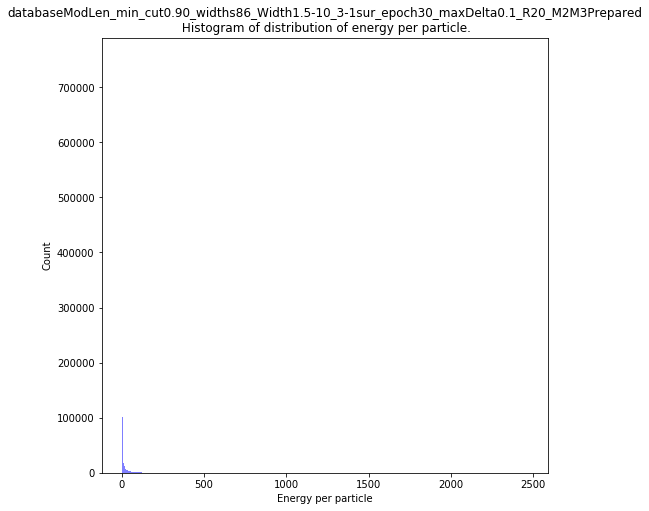

47.07930051714119
Mean 11.446222312469528 STD: None
609.6803960245963
[2466.3866155396, 2177.3709585242, 2062.2108467001, 2053.9389581995]


In [136]:
allEigenvalues =[]
[[allEigenvalues.append(abs(j)) for j in trainingInput['input'][i]] for i in range(len(trainingInput['input']))]

allEigenvalues = np.array(allEigenvalues)

fig, ax = plt.subplots(figsize=(8, 8))
n, bins, patches = ax.hist(allEigenvalues, 1000, facecolor='blue', alpha=0.5)
ax.set_title(filename + '\n Histogram of distribution of energy per particle.')
ax.set_xlabel('Energy per particle')
ax.set_ylabel('Count')
plt.show()

print('Mean', np.mean(allEigenvalues), 'STD:', print(np.std(allEigenvalues)))
print(np.percentile(allEigenvalues, 99.9))
print([np.sort(allEigenvalues)[-i] for i in range(1, 5)])

## Preparing test data

In [137]:
"""
widthOfCell = 5.0
numberOfSurroundingCells = 3
R0 = 20
x = np.linspace(0.1, 1.1, 60)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.1, 0.1]), np.array([0.55, 0.9]), np.array([0.6, 0.665]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), [testData['eigenvalues'][i] for i in range(len(testData['eigenvalues']))])
ax1.legend()
ax1.set_ylim(-1000, 1000)
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Eigenvalues')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()

y = []
for i in range(len(x)):
    y.append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y, label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()
#"""
print()

# Machine learning

In [138]:
models = []
prefixName = 0
saveFolder = 'testRun'
lossMetric = 'MAE'#keras.losses.MeanAbsoluteError()#keras.losses.MeanSquaredError()
#trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
#fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))

def RSMPE(target,value):
    return ((keras.backend.mean(((value-target)/target)**2))**0.5)*100

def MAE(target,value):
    return keras.backend.mean(abs(value-target))


## Try linear network

In [16]:
def makeRandomNumberDatabaseSum(amountOfData, amountOfInputs=8, sigma=10**5):
    X = []
    y = []
    for i in range(amountOfData):#data.index:
        randomNumbers = [random.gauss(0, sigma) for j in range(0,amountOfInputs)]#[random.uniform(-maximalNumbers, maximalNumbers) for j in range(0,amountOfInputs)]

        X.append(randomNumbers)
        y.append(sum(randomNumbers))

    X = np.array(X)
    Y = np.array(y)

    return X, Y

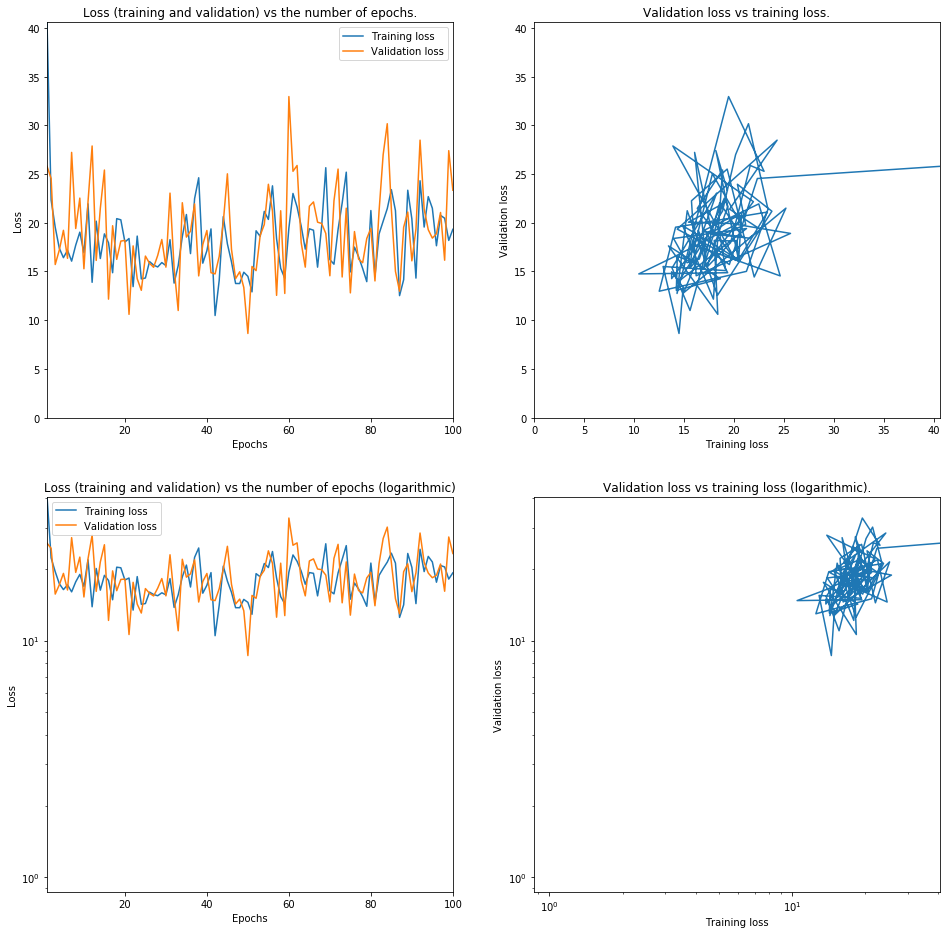

Amount of data 1000 Learning rate: 1.0 Amount of epochs: 26 Final loss: 18.19118606087302


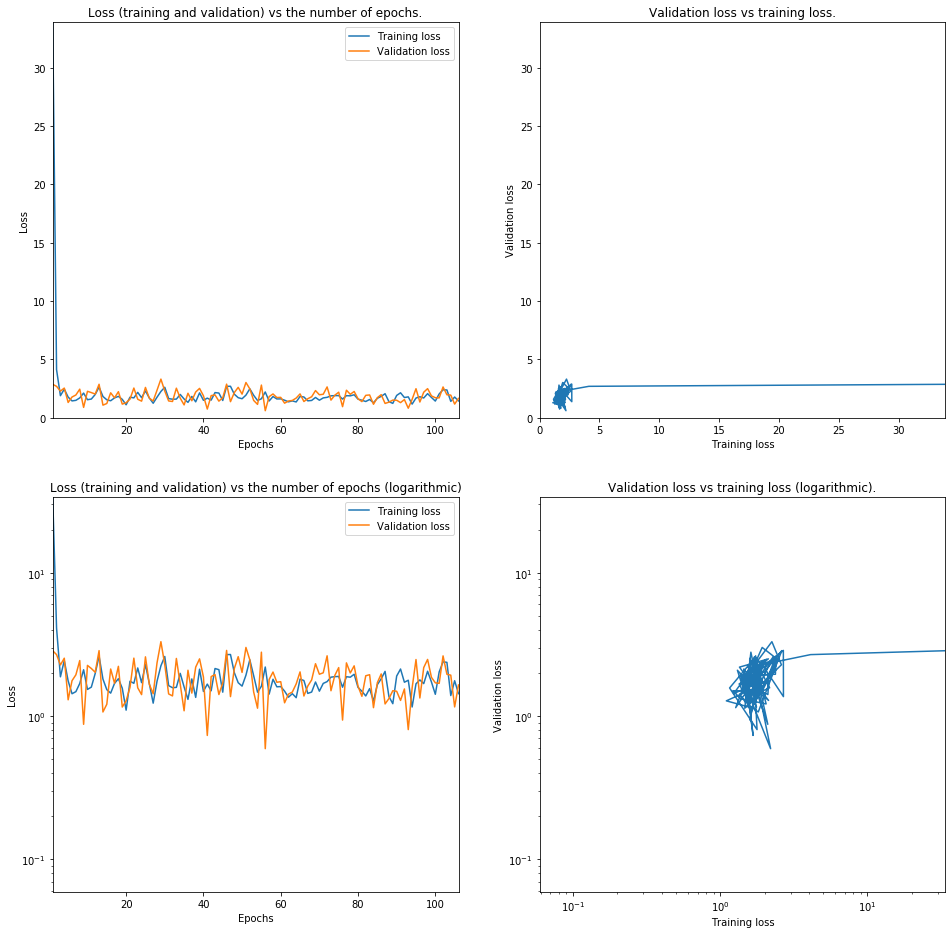

Amount of data 1000 Learning rate: 0.1 Amount of epochs: 31 Final loss: 1.722721593431875


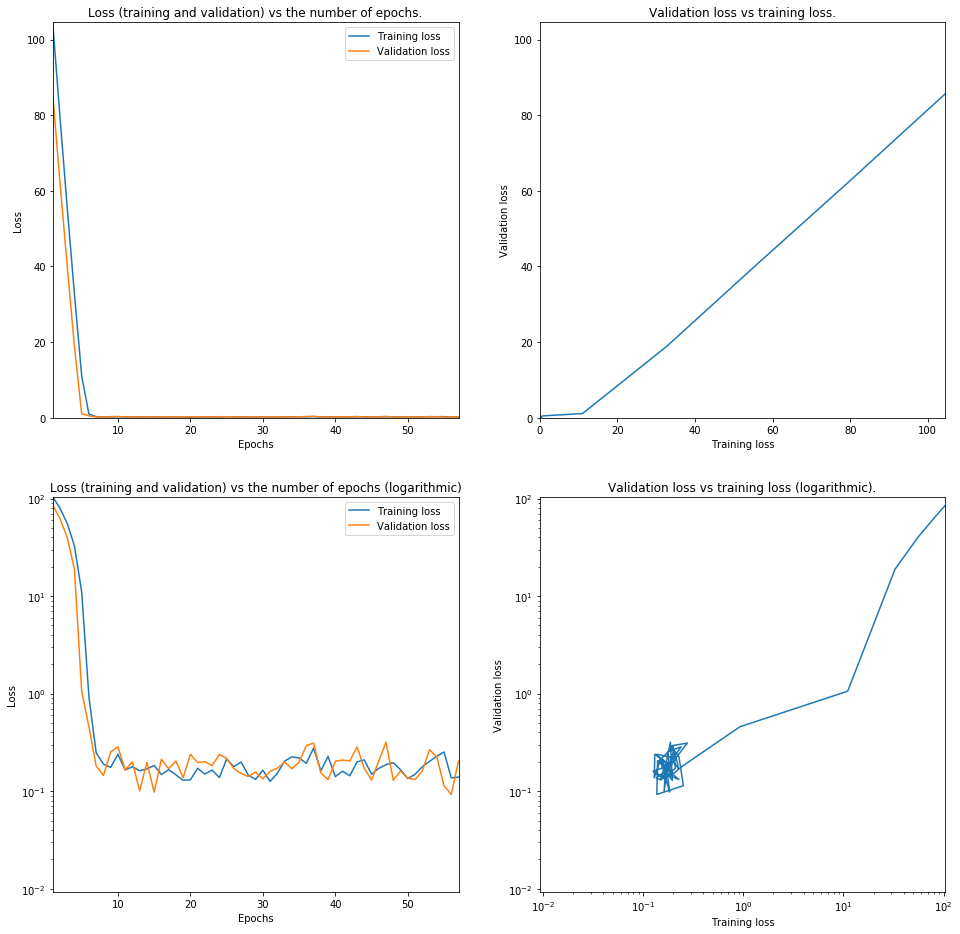

Amount of data 1000 Learning rate: 0.01 Amount of epochs: 8 Final loss: 0.1764330270521495


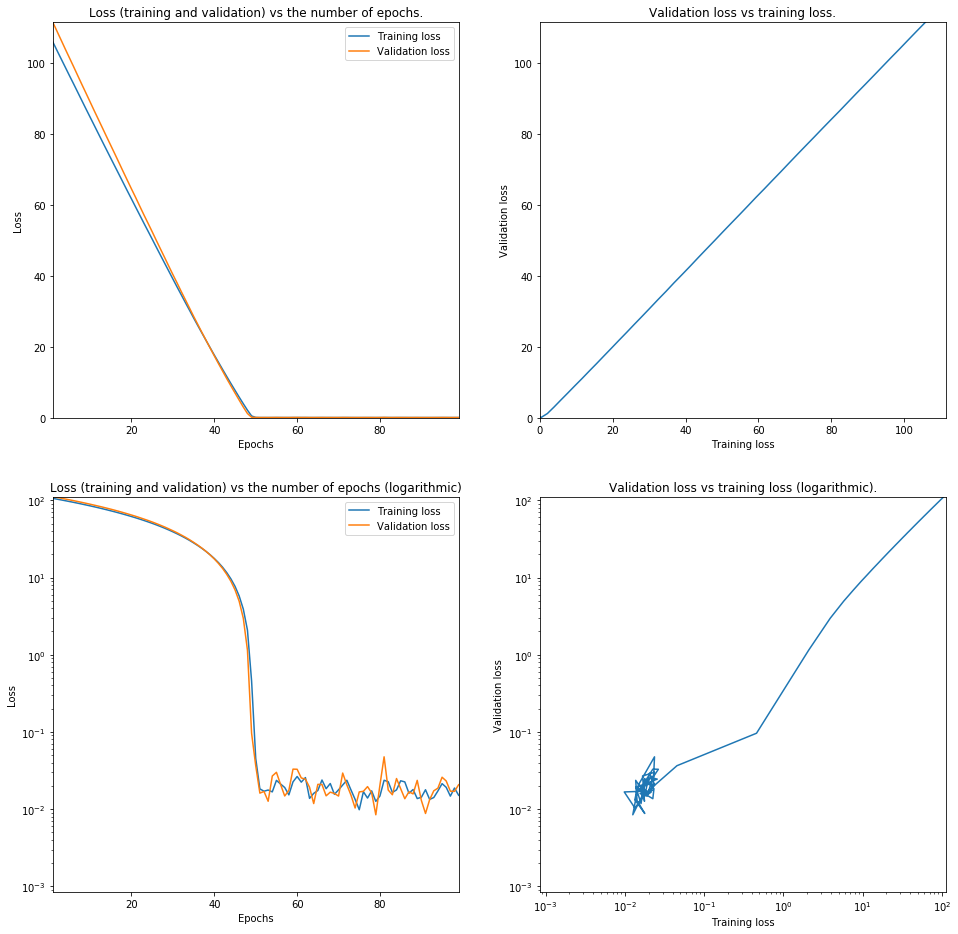

Amount of data 1000 Learning rate: 0.001 Amount of epochs: 47 Final loss: 0.01856367627541427


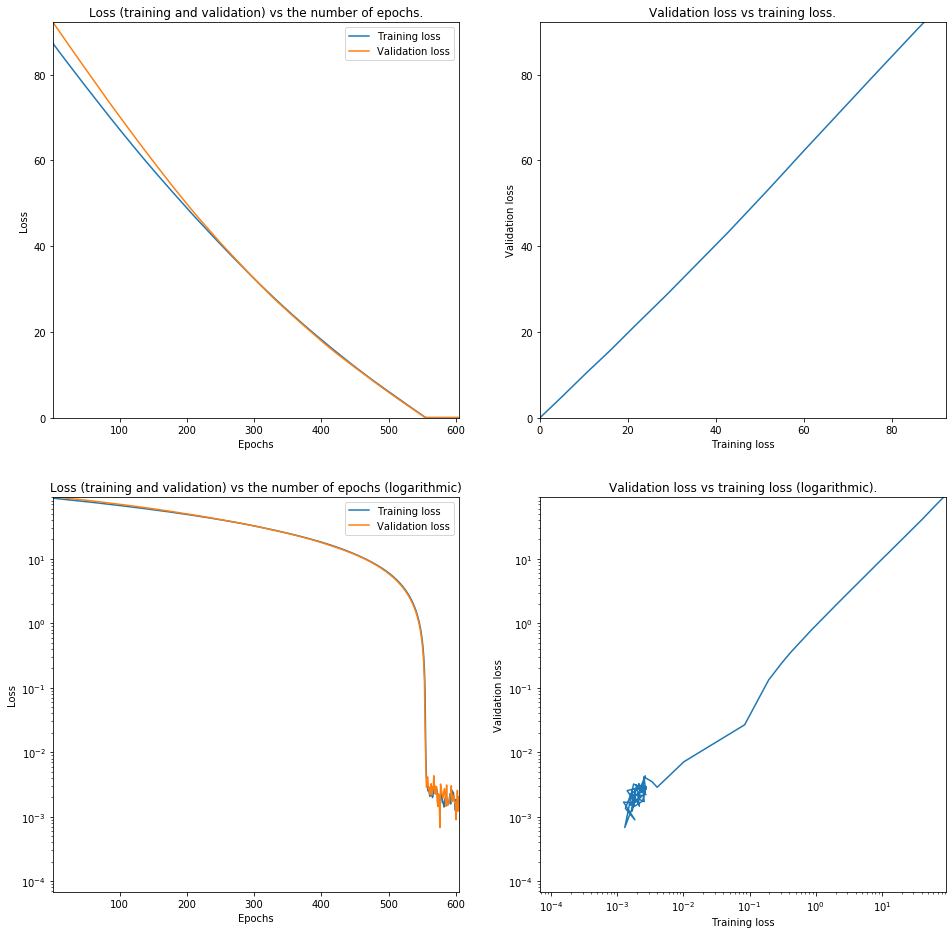

Amount of data 1000 Learning rate: 0.0001 Amount of epochs: 540 Final loss: 0.0020377262799310034


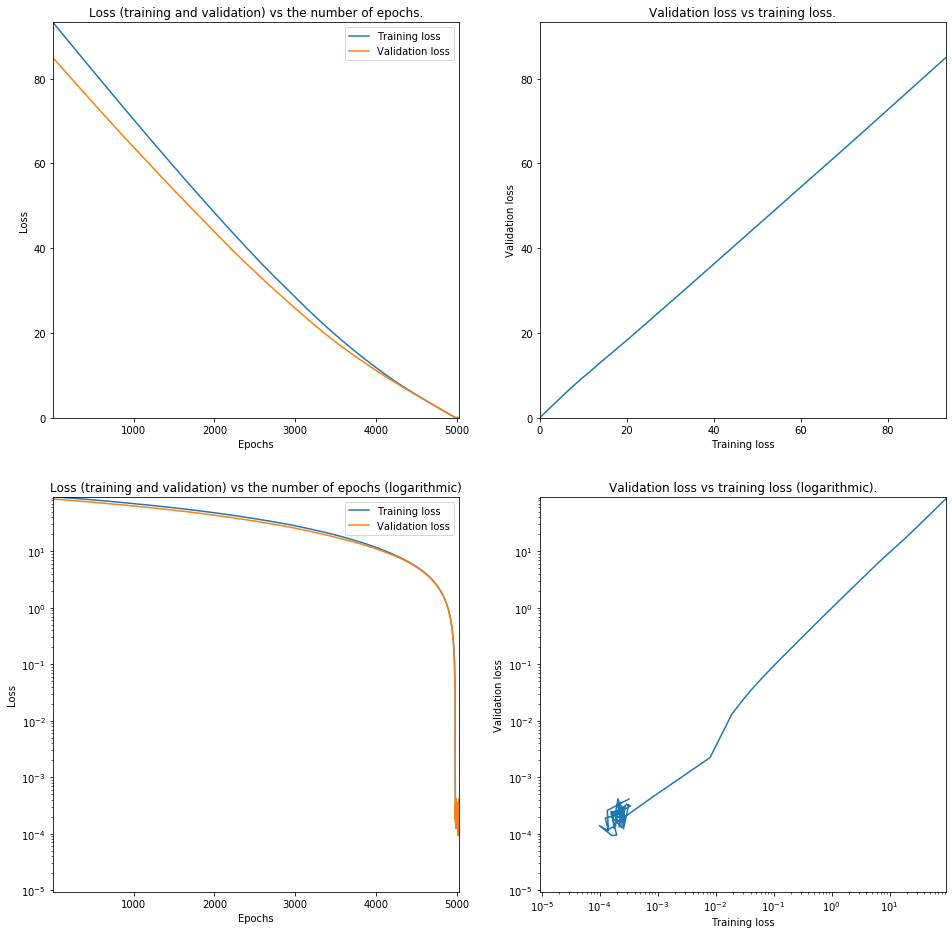

Amount of data 1000 Learning rate: 1e-05 Amount of epochs: 5282 Final loss: 0.01011027320773423


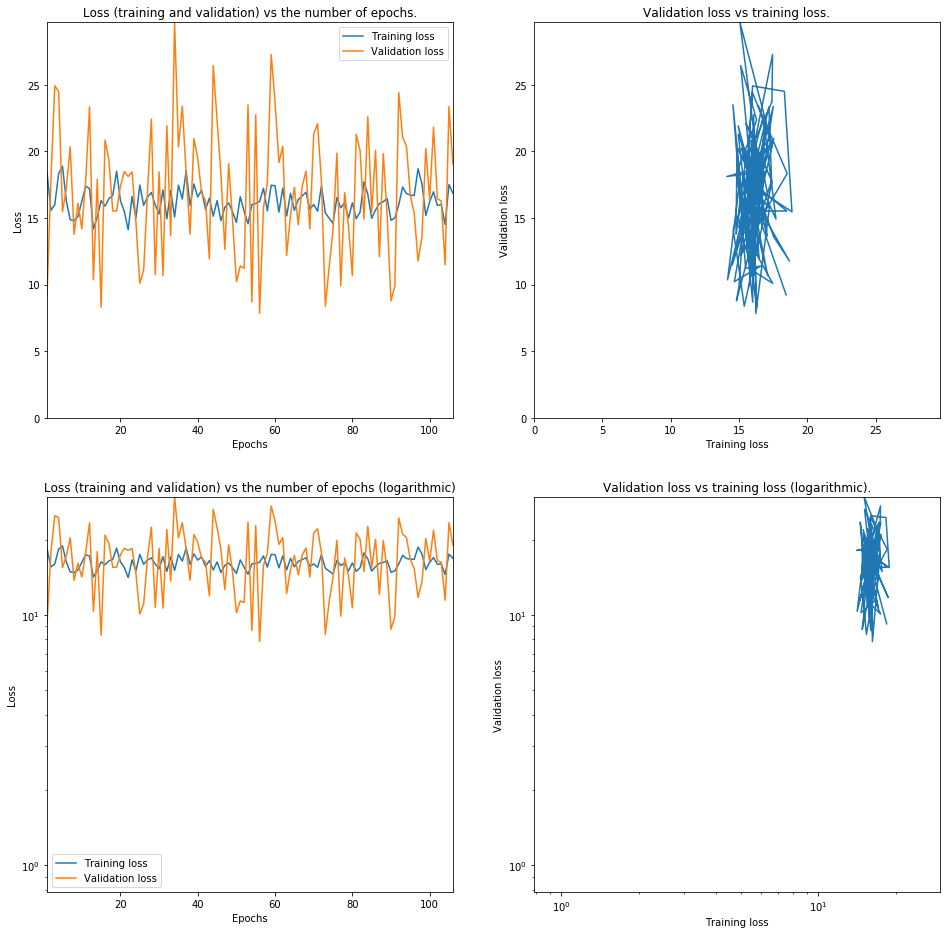

Amount of data 10000 Learning rate: 1.0 Amount of epochs: 88 Final loss: 16.30714410507825


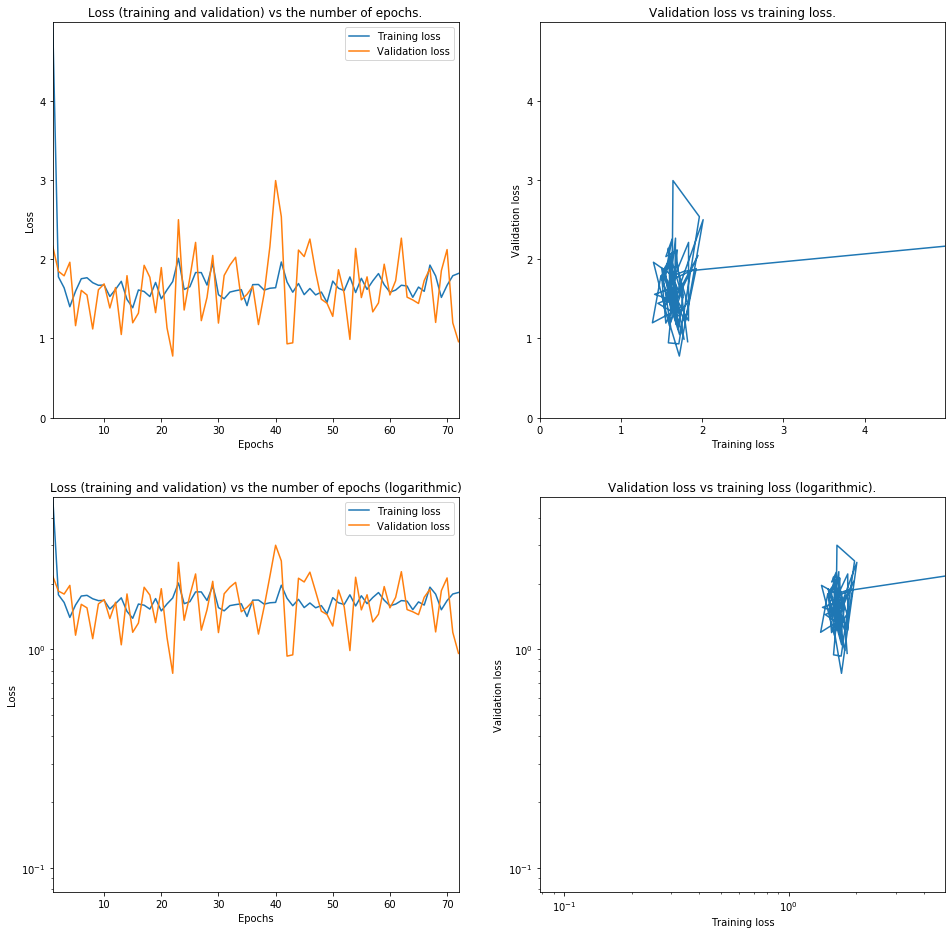

Amount of data 10000 Learning rate: 0.1 Amount of epochs: 25 Final loss: 1.6437369041215806


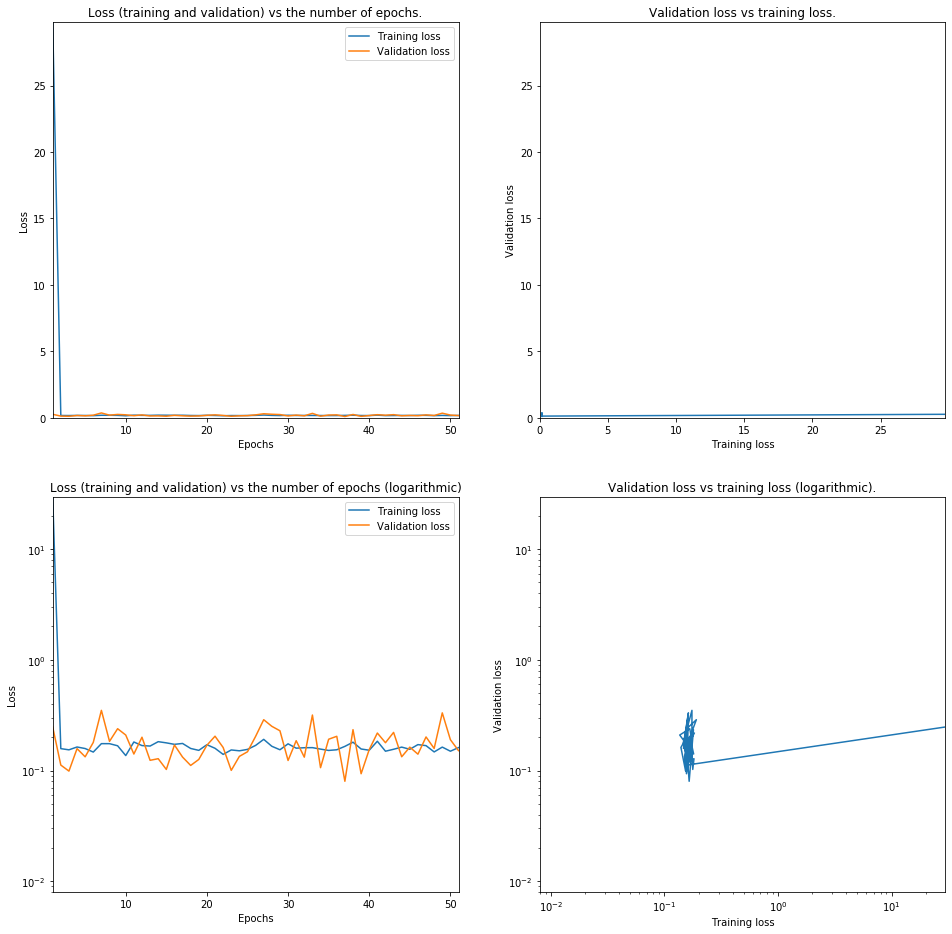

Amount of data 10000 Learning rate: 0.01 Amount of epochs: 1 Final loss: 0.16342150791368518


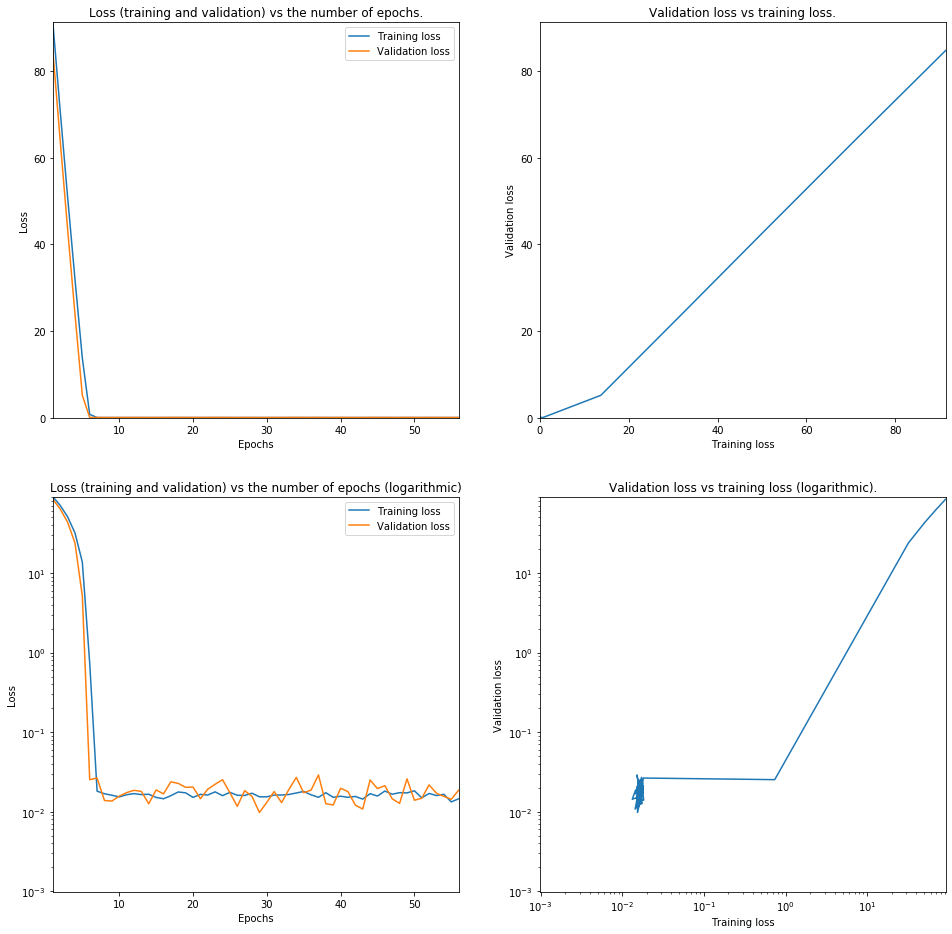

Amount of data 10000 Learning rate: 0.001 Amount of epochs: 5 Final loss: 0.016220807055784325


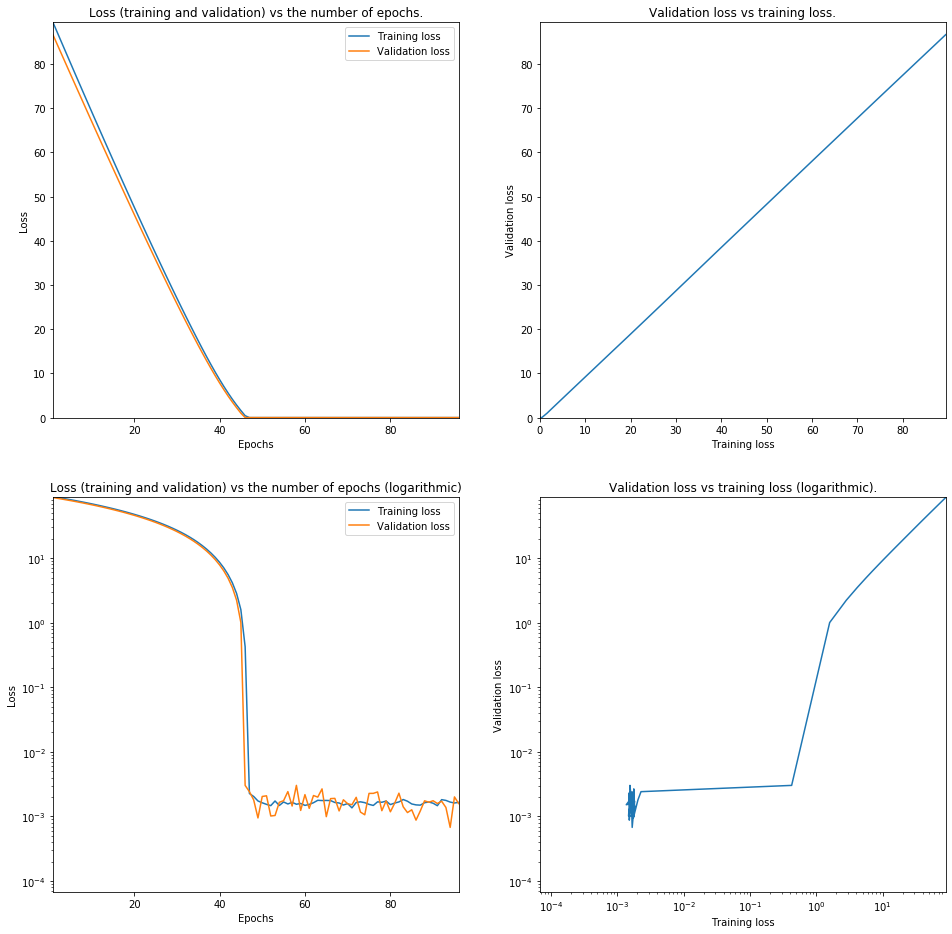

Amount of data 10000 Learning rate: 0.0001 Amount of epochs: 56 Final loss: 0.001634034008228657


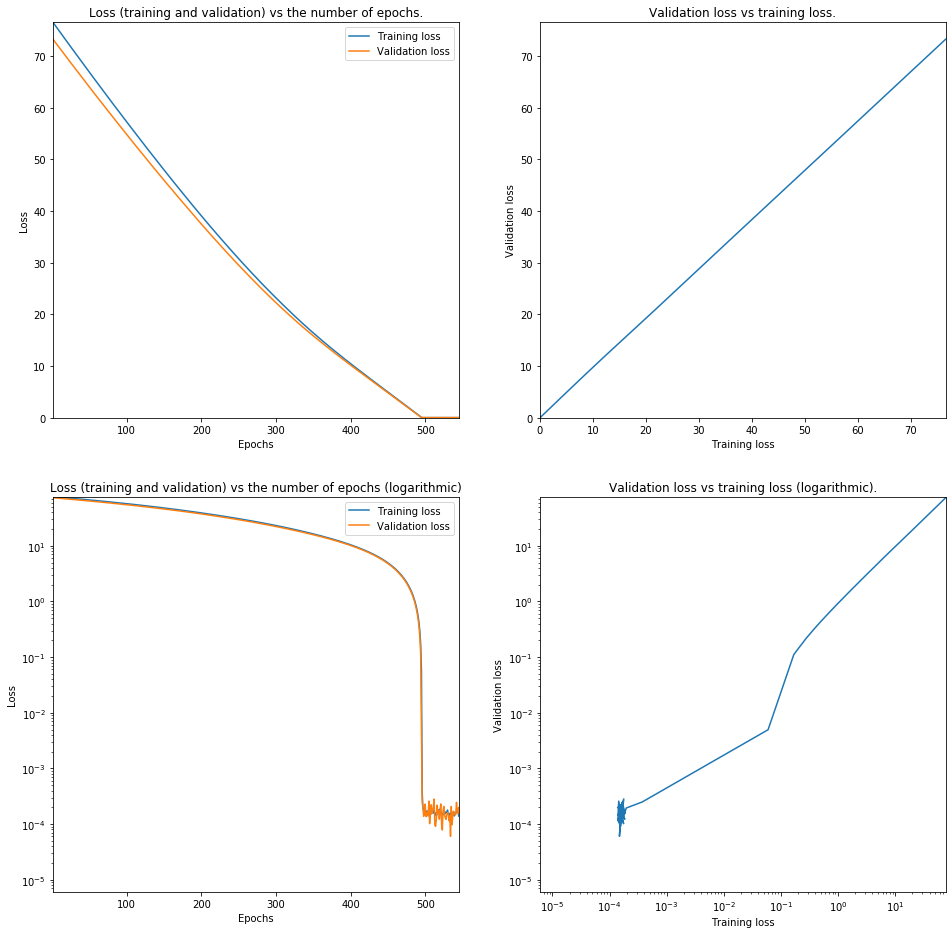

Amount of data 10000 Learning rate: 1e-05 Amount of epochs: 569 Final loss: 0.00016457329159729232


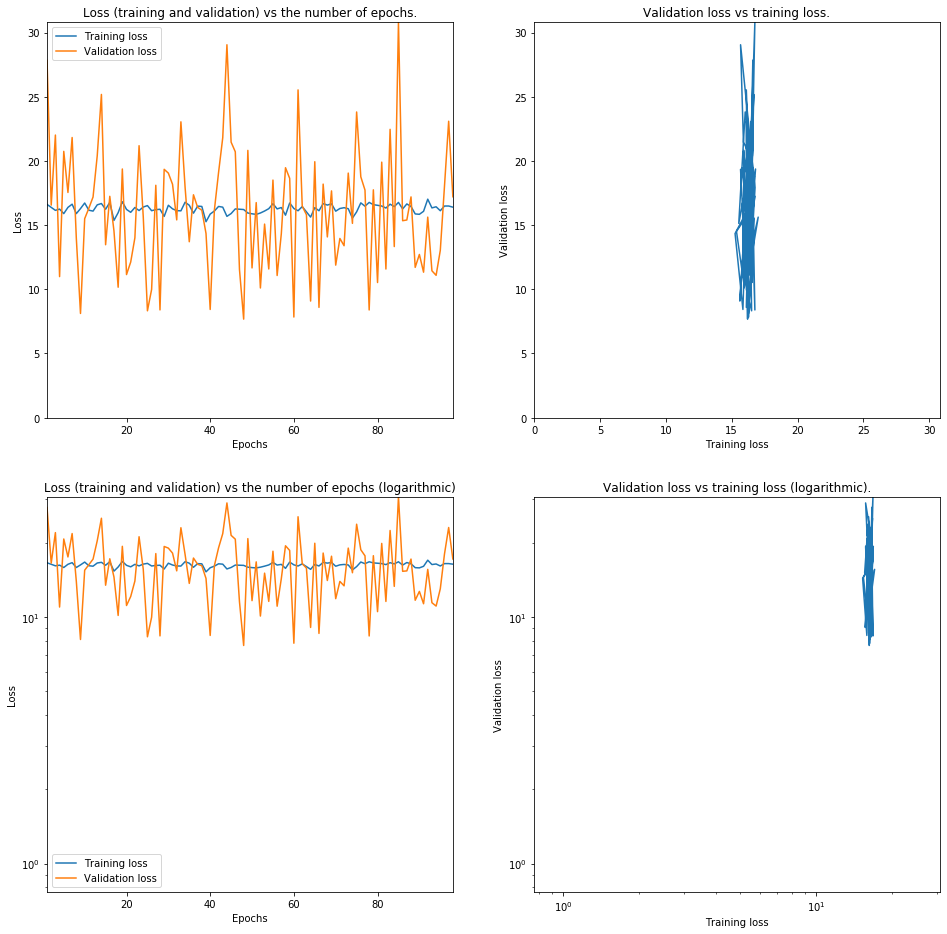

Amount of data 100000 Learning rate: 1.0 Amount of epochs: 36 Final loss: 16.274190460474443


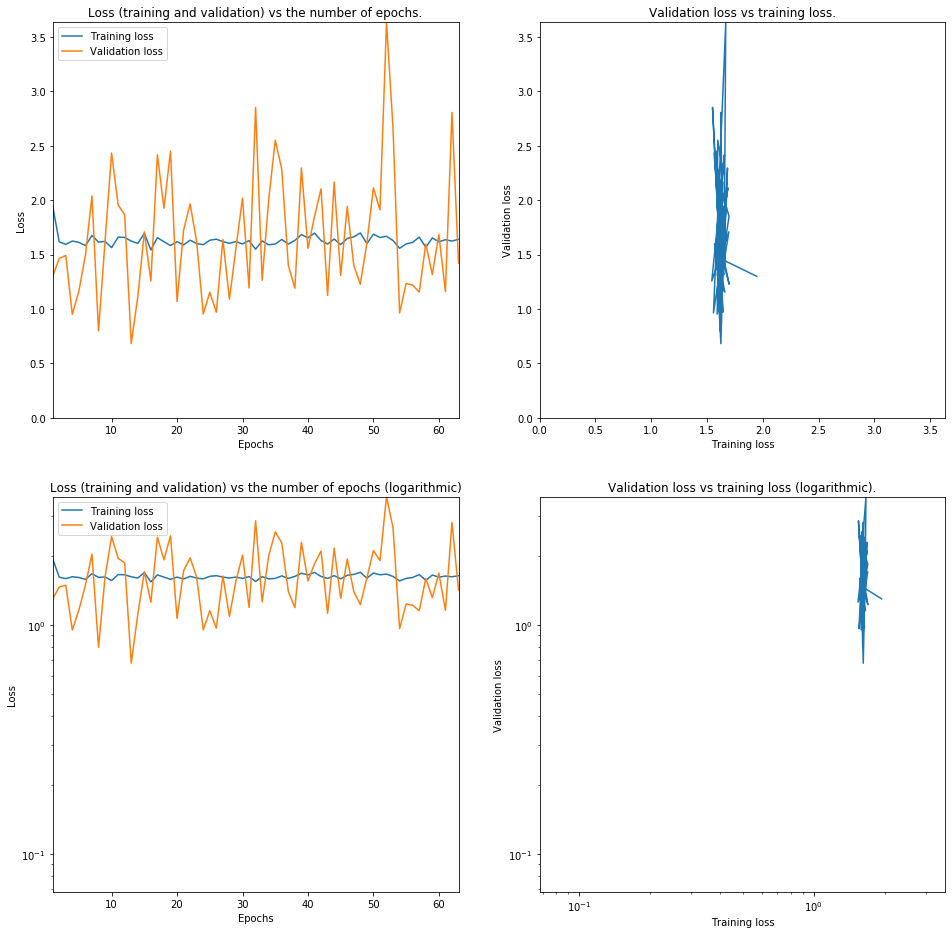

Amount of data 100000 Learning rate: 0.1 Amount of epochs: 13 Final loss: 1.6233555304270375


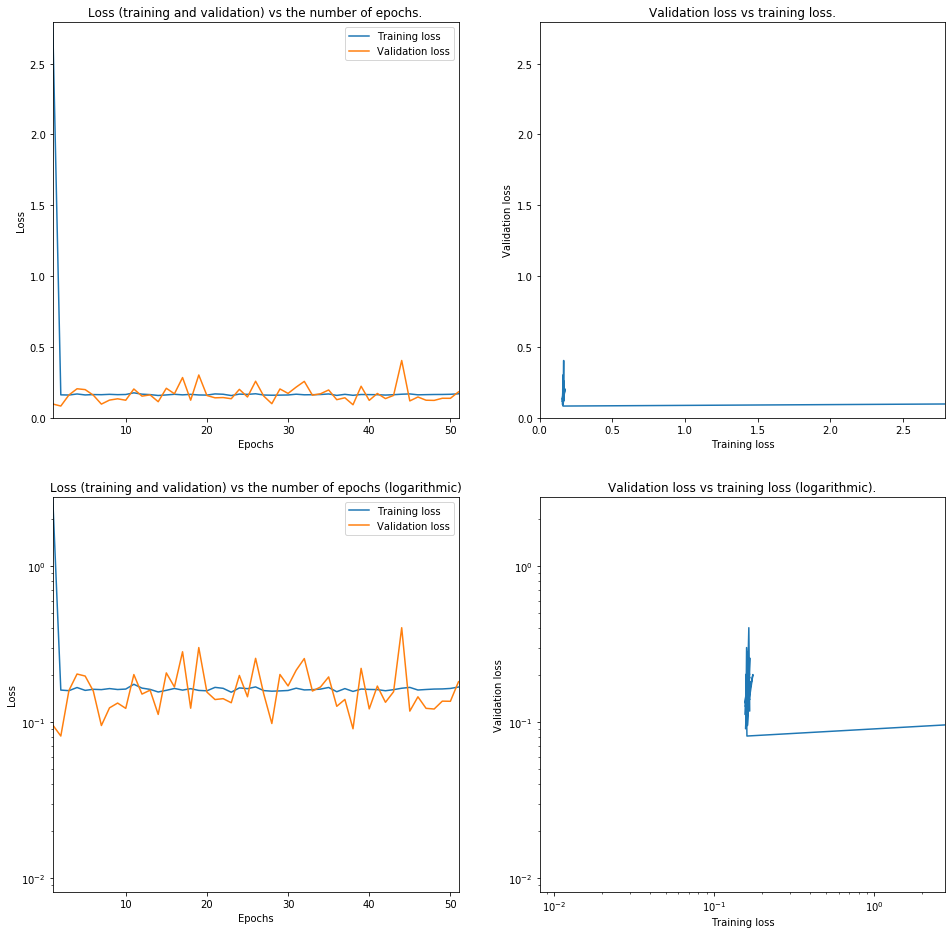

Amount of data 100000 Learning rate: 0.01 Amount of epochs: 1 Final loss: 0.16305260479371564


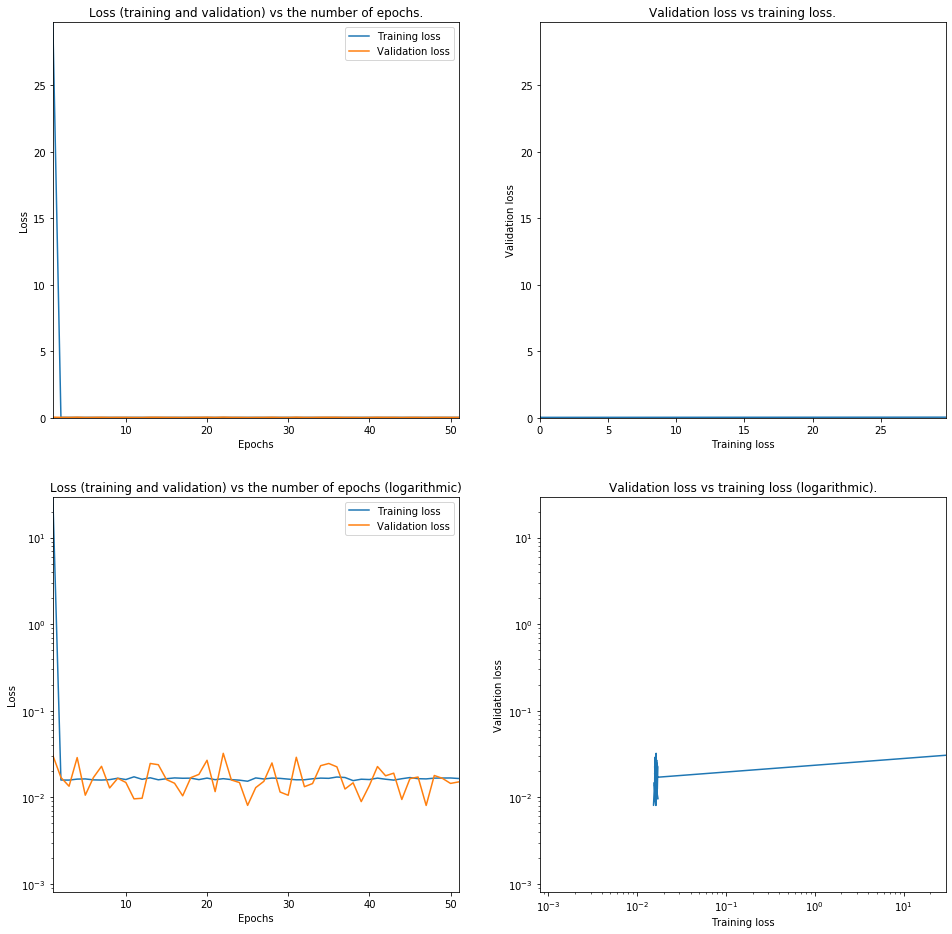

Amount of data 100000 Learning rate: 0.001 Amount of epochs: 1 Final loss: 0.01627522287307751


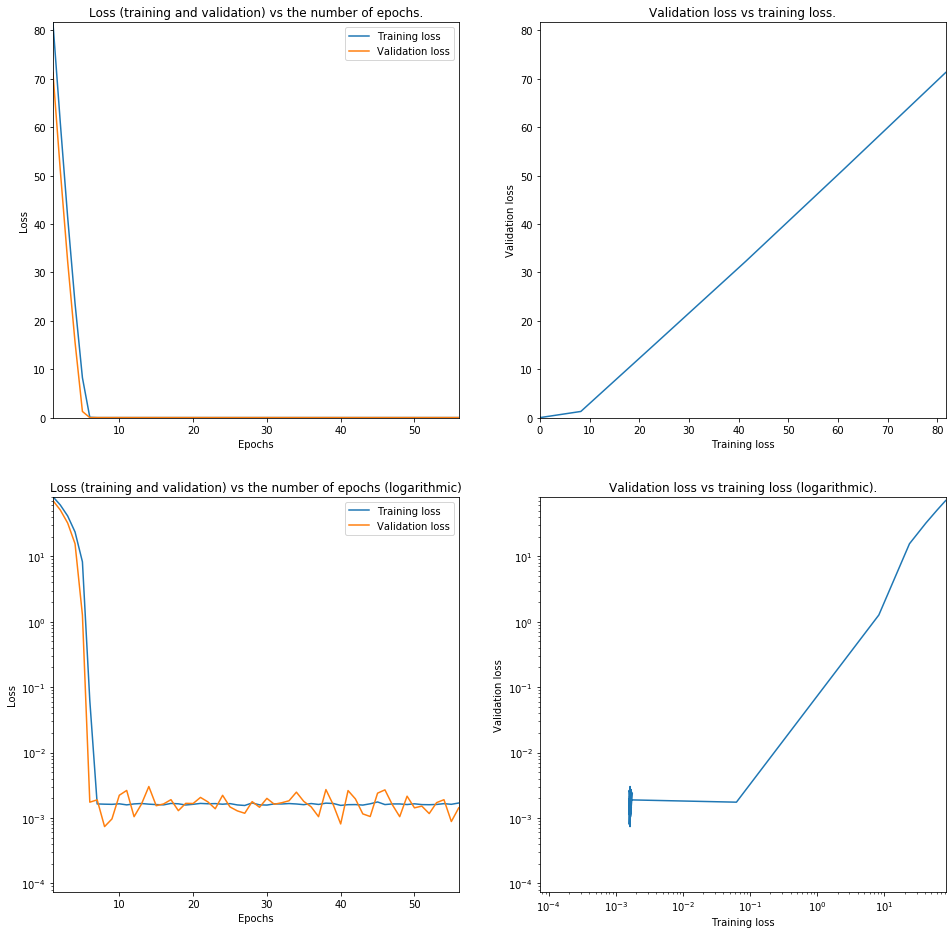

Amount of data 100000 Learning rate: 0.0001 Amount of epochs: 6 Final loss: 0.0016231362625641662


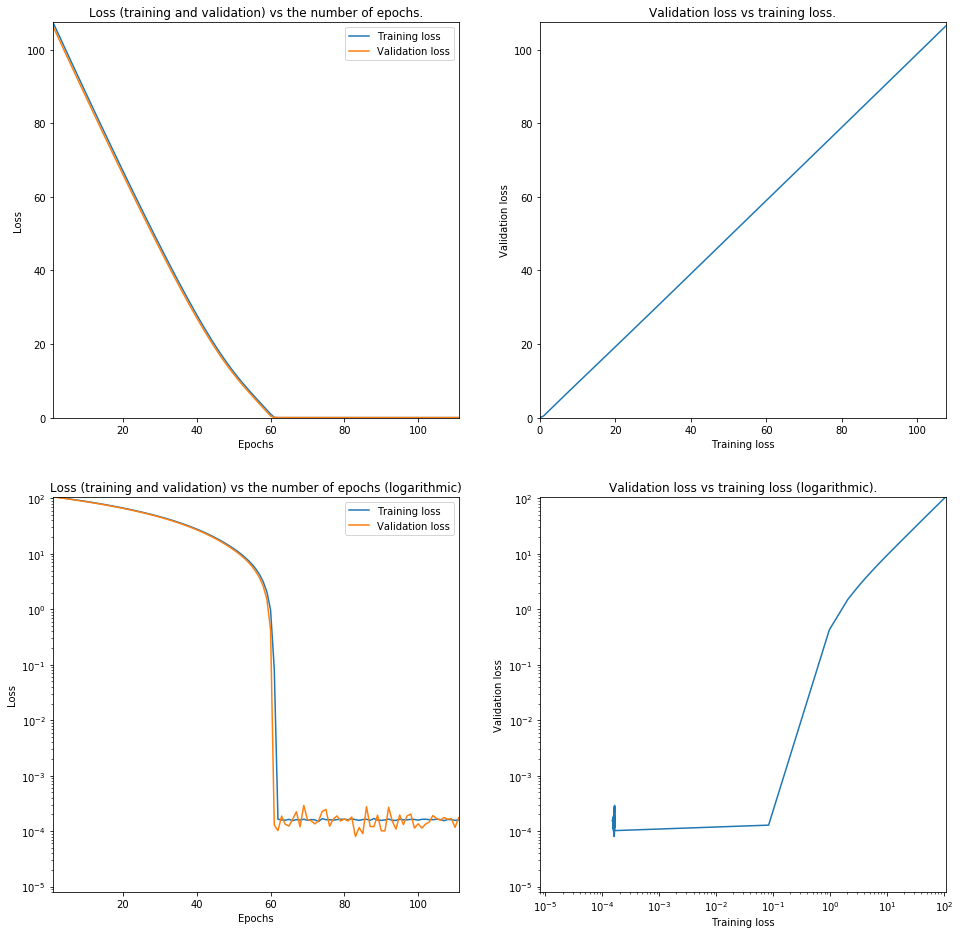

Amount of data 100000 Learning rate: 1e-05 Amount of epochs: 57 Final loss: 0.00016081113790835058


In [18]:
name = 'LinearNetwork'
settingsLineaerNet = [['Dense', 1, 'linear', False]]

maxEpochs = 10000

learningRate = []
amountOfData = []

repeat = 3
resulutionOfData = 3
resulutionOfLearning = 6

results = {'amountOfEpochs':[], 'finalLoss':[]}
for i in np.logspace(3, 5, resulutionOfData):
    i = math.ceil(i)
    amountOfData.append(i)
    
    resultsEpochs = []
    resultsLoss = []
    
    learningRateTemp = []
    
    for j in np.logspace(0, -5, resulutionOfLearning):
        learningRateTemp.append(j)
        
        resultsLossTemp = []
        resultsEpochsTemp = []
        
        
        for re in range(repeat):
            dataPointsX, dataPointsY = makeRandomNumberDatabaseSum(math.ceil(i/0.9), 8, 10*7)
            model = makeDenseNetwork(8, settingsLineaerNet, j, kernalInitializer='he_uniform', lossFunction=MAE)
            earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)
            fitDetails = model.fit(dataPointsX, dataPointsY, epochs=maxEpochs, validation_split=0.1, verbose=0, callbacks=[earlyStop])
            loss = fitDetails.history['loss']
            resultsEpochsTemp.append(len(fitDetails.history['loss'])-50)
            resultsLossTemp.append(np.mean([loss[-k] for k in range(1, 50)]))
            
            
        history = plotHistory(fitDetails)
        resultsEpochs.append(math.ceil(np.mean(resultsEpochsTemp)))
        resultsLoss.append(np.mean(resultsLossTemp))
        
        print('Amount of data', math.ceil(i), 'Learning rate:', j, 'Amount of epochs:', resultsEpochs[-1], 'Final loss:', resultsLoss[-1])
    
    results['amountOfEpochs'].append(resultsEpochs)
    results['finalLoss'].append(resultsLoss)
    learningRate.append(learningRateTemp)



Dataset of size 1000
[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
[26, 31, 8, 47, 540, 5282]
[18.19118606087302, 1.722721593431875, 0.1764330270521495, 0.01856367627541427, 0.0020377262799310034, 0.01011027320773423]


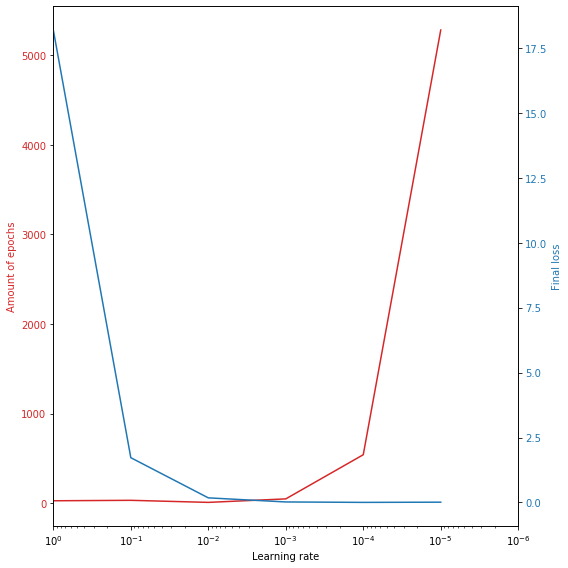

Dataset of size 10000
[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
[88, 25, 1, 5, 56, 569]
[16.30714410507825, 1.6437369041215806, 0.16342150791368518, 0.016220807055784325, 0.001634034008228657, 0.00016457329159729232]


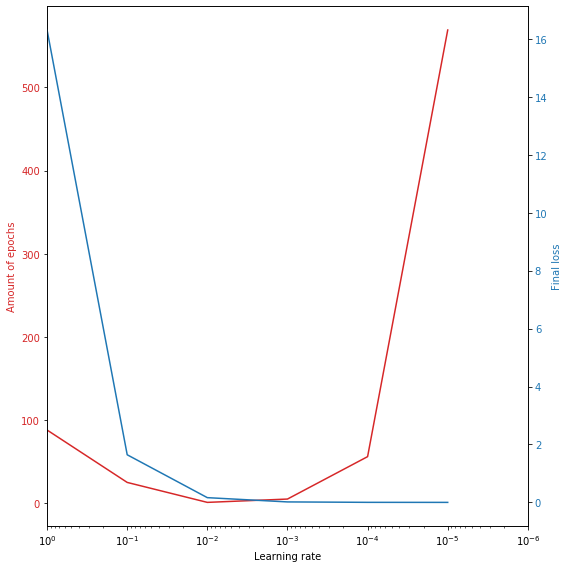

Dataset of size 100000
[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
[36, 13, 1, 1, 6, 57]
[16.274190460474443, 1.6233555304270375, 0.16305260479371564, 0.01627522287307751, 0.0016231362625641662, 0.00016081113790835058]


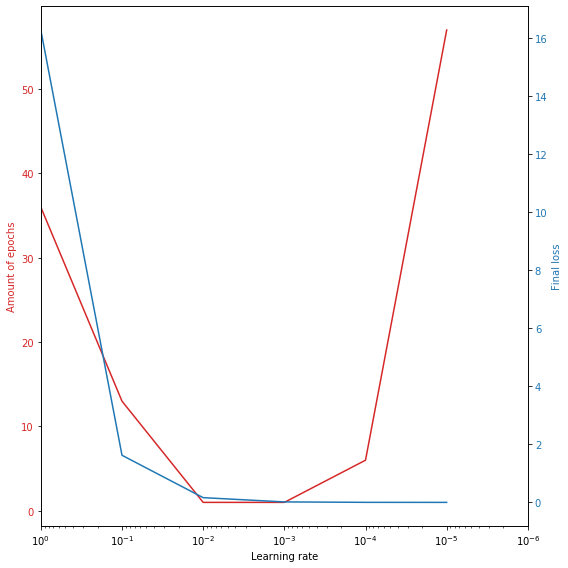

In [19]:
selection=1

for i in range(0, len(amountOfData)):
    print('Dataset of size', amountOfData[i])
    print(learningRate[i])
    print(results['amountOfEpochs'][i])
    print(results['finalLoss'][i])
    fig, ax1 = plt.subplots(figsize=(8, 8))
    color = 'tab:red'
    ax1.set_xlabel('Learning rate')
    ax1.set_xscale('log')
    ax1.set_xlim(10**0, 10**-6)
    ax1.set_ylabel('Amount of epochs', color=color)
    ax1.plot(learningRate[i], results['amountOfEpochs'][i], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Final loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(learningRate[i], results['finalLoss'][i], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Testing optimizers on real data

In [ ]:
settingsLineaerNet = [['Dense', 1, 'linear', False]]
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

optimizers = [SGD, adam, nadam, adagrad, rmsprop, adadelta]

for i in range(len(optimizers)):
    for j in np.logspace(-4, -8, 9):
        print('Optimizer:', i, 'learning rate:', j)
        model = makeDenseNetwork(21, settingsLineaerNet, j, kernalInitializer='he_uniform', lossFunction=MAE, optimizer=optimizers[i])
        model.layers[0].set_weights([np.array([[1] for i in range(21)])])
        #model.layers[0].set_weights([np.array([[random.uniform(0.5, 1.5)] for i in range(8)])])
        
        fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=50, verbose=0, callbacks=callbacksNetwork)
        history = plotHistory(fitDetails)

## Linear network real data

In [139]:
name = 'LinearNetwork'
settingsLineaerNet = [['Dense', 1, 'linear', False]]
learningRate = 1*10**-4
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, optimizer=adam)
#model.layers[0].set_weights([np.array([[1] for i in range(inputSize)])])
#model.layers[0].set_weights([np.array([[random.uniform(0.5, 1.5)] for i in range(inputSize)])])


model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
print(model.evaluate(trainingInput['input'], trainingInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
12990/12990 [==============================] - 0s 34us/step
45.87665527026593
51960/51960 [==============================] - 2s 31us/step
45.59699055096844
Layer 0:  [array([[ 0.16435963],
       [ 0.26445168],
       [ 0.23215455],
       [ 0.34329444],
       [ 0.23423296],
       [ 0.26186097],
       [ 0.07041103],
       [-0.37454462],
       [-0.10739097],
       [ 0.23442566],
       [-0.15588763],
       [-0.14684385],
       [ 0.19084561],
       [ 0.4724887 ],
       [-0.07002527],
       [-0.15204647],
       [-0.51644075],
       [-0.4421627 ],
       [-0.31667906],
       [-0.09765887],
       [-0.10568786]], dtype=float32)]


Train on 36372 samples, validate on 15588 samples
Epoch 1/100
36372/36372 [==============================] - 3s 80us/step - loss: 33.2121 - val_loss: 23.5625
Epoch 2/100
36372/36372 [==============================] - 3s 76us/step - loss: 18.0828 - val_loss: 17.5799
Epoch 3/100
36372/36372 [==============================] - 3s 75us/step - loss: 15.8563 - val_loss: 15.8877
Epoch 4/100
36372/36372 [==============================] - 3s 77us/step - loss: 14.2656 - val_loss: 14.2113
Epoch 5/100
36372/36372 [==============================] - 3s 79us/step - loss: 12.7861 - val_loss: 12.8022
Epoch 6/100
36372/36372 [==============================] - 3s 75us/step - loss: 11.7342 - val_loss: 12.0765
Epoch 7/100
36372/36372 [==============================] - 3s 80us/step - loss: 11.2974 - val_loss: 11.8276
Epoch 8/100
36372/36372 [==============================] - 3s 80us/step - loss: 11.1421 - val_loss: 11.7286
Epoch 9/100
36372/36372 [==============================] - 3s 75us/step - loss: 11.079

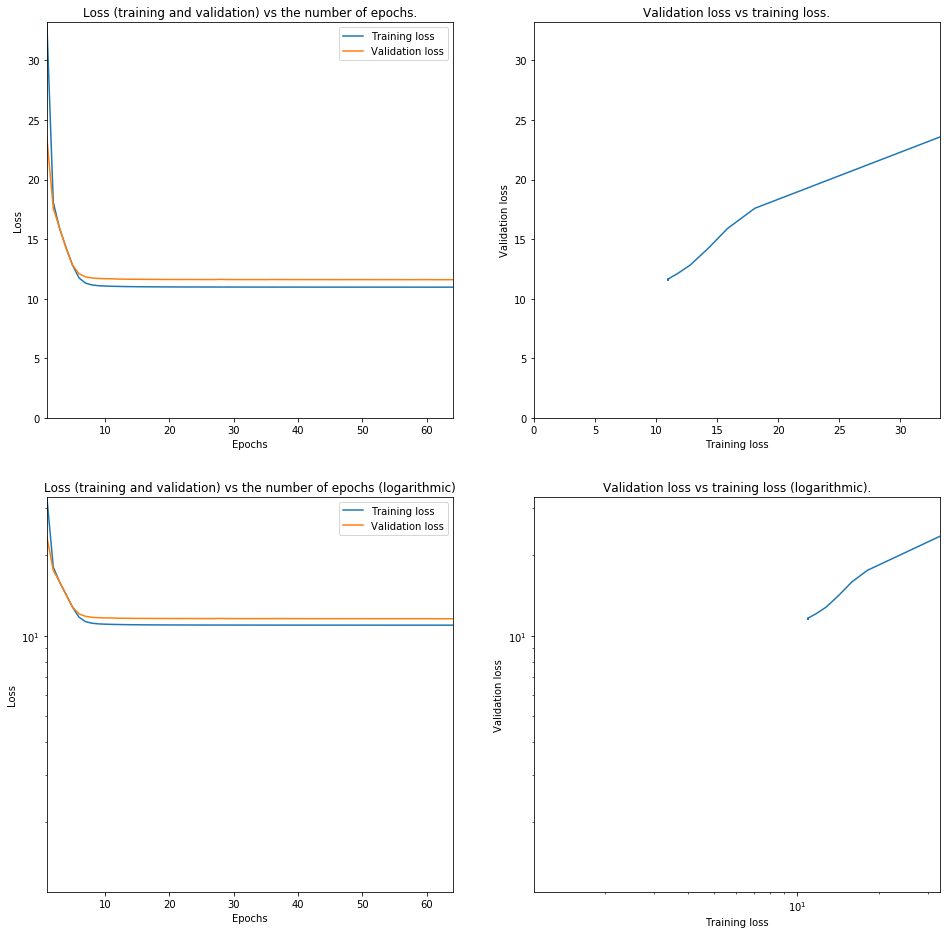

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
10.267164193198164
Layer 0:  [array([[-0.6520933 ],
       [ 0.26445168],
       [ 0.23215455],
       [ 0.34329444],
       [ 0.23423296],
       [-0.09905754],
       [ 0.16514896],
       [-0.08332141],
       [ 0.02703478],
       [ 0.24802452],
       [-0.02084306],
       [-0.14684385],
       [ 0.19084561],
       [ 0.4724887 ],
       [-0.07002527],
       [ 0.03518568],
       [-0.02645183],
       [ 0.01264816],
       [-0.00475515],
       [-0.02577796],
       [ 0.00623482]], dtype=float32)]


In [140]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=100, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

## Real data complex network

In [ ]:
name = '1DenseLayerNetwork'
settingsLineaerNet = [['Dense', 128, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 1*10**-4
callbacksNetwork = []#[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, optimizer=adam)
#model.layers[0].set_weights([np.array([[1] for i in range(inputSize)])])
#model.layers[0].set_weights([np.array([[random.uniform(0.5, 1.5)] for i in range(inputSize)])])


model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
print(model.evaluate(trainingInput['input'], trainingInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

In [ ]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=100, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

## Real very complex data

In [143]:
name = '2DenseLayerNetwork'
settingsLineaerNet = [['Dense', 128, 'softplus', False], ['Dense', 128, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 1*10**-4
callbacksNetwork = []#[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, optimizer=adam)
#model.layers[0].set_weights([np.array([[1] for i in range(inputSize)])])
#model.layers[0].set_weights([np.array([[random.uniform(0.5, 1.5)] for i in range(inputSize)])])


model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
print(model.evaluate(trainingInput['input'], trainingInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 128)               2688      
_________________________________________________________________
dense_68 (Dense)             (None, 128)               16384     
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 128       
Total params: 19,200
Trainable params: 19,200
Non-trainable params: 0
_________________________________________________________________
12990/12990 [==============================] - 1s 46us/step
58.67880375416486
51960/51960 [==============================] - 2s 47us/step
57.905595531272745
Layer 0:  [array([[-0.15309188,  0.53321785, -0.03937811, ..., -0.18066022,
         0.26509398, -0.10167539],
       [ 0.15302354, -0.31625494,  0.27628845, ...,  0.4443674 ,
         0.10482228,  0.22612178],
       [-0.

In [144]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=200, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Train on 36372 samples, validate on 15588 samples
Epoch 1/200
36372/36372 [==============================] - 5s 129us/step - loss: 11.2963 - val_loss: 10.7214
Epoch 2/200
36372/36372 [==============================] - 5s 127us/step - loss: 10.0891 - val_loss: 10.8352
Epoch 3/200
36372/36372 [==============================] - 4s 103us/step - loss: 10.0560 - val_loss: 10.6599
Epoch 4/200
36372/36372 [==============================] - 4s 121us/step - loss: 9.9906 - val_loss: 10.5200
Epoch 5/200
36372/36372 [==============================] - 4s 101us/step - loss: 9.9659 - val_loss: 10.8409
Epoch 6/200
36372/36372 [==============================] - 3s 95us/step - loss: 9.9302 - val_loss: 10.5331
Epoch 7/200
36372/36372 [==============================] - 3s 93us/step - loss: 9.8896 - val_loss: 10.6133
Epoch 8/200
36372/36372 [==============================] - 3s 90us/step - loss: 9.8957 - val_loss: 10.4203
Epoch 9/200
36372/36372 [==============================] - 3s 83us/step - loss: 9.8433

KeyboardInterrupt: 

# TEMP

In [ ]:
print(np.shape(trainingInput['input']))
print(np.shape(trainingInput['target']))

In [ ]:
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
#print(dataset)
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]

print(np.shape(X))
print(np.shape(y))
print(X)
print(y)

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=150, batch_size=10)